<a href="https://colab.research.google.com/github/lys678/AIFFEL_QUEST/blob/main/Exploration/EX04/CIFAR_10_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : CIFAR-10 이미지 생성하기

주요 라이브러리 버전을 확인하고 진행합니다.

In [ ]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기

폴더를 만들어 작업환경을 구성합니다.

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
# train_x를 정규화하는 코드

train_x = (train_x - 127.5)/127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
# 데이터셋의 shape

train_x.shape

(50000, 32, 32, 3)

- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


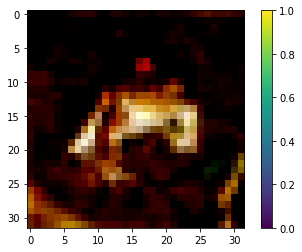

In [ ]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

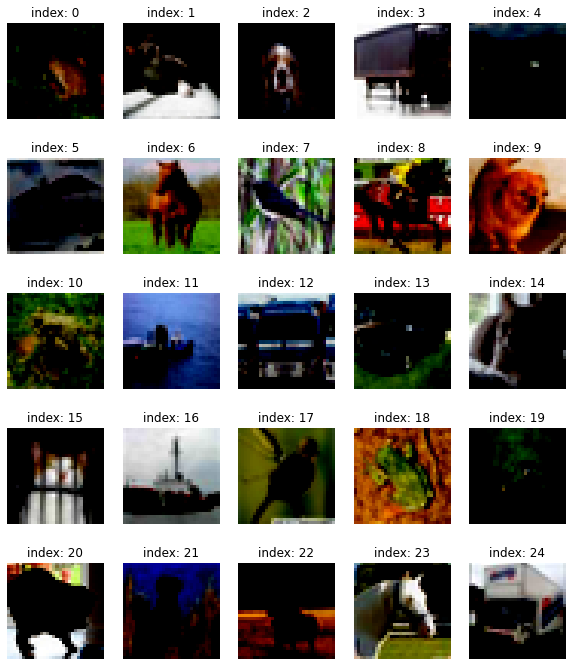

In [ ]:
# for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워봅니다. 단, 모든 이미지는 train_images에서 랜덤으로 추출해 보겠습니다.
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[np.random.randint(1,50000)])
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [ ]:
# 미니 배치 학습
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units는 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

In [ ]:
# 노이즈 벡터
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

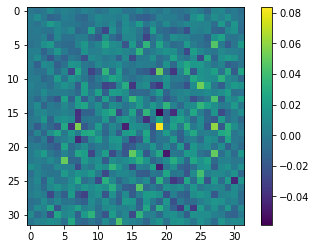

In [ ]:
# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.

In [ ]:
# 판별자 구현하기
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 컬러 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## STEP 5. 손실함수와 최적화 함수 구현하기

In [ ]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# discriminator accuracy
# real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
# 최적화 함수를 설정, Adam 이용
# 학습률=1e-4
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
noise_dim = 100  # 100차원의 노이즈
num_examples_to_generate = 16  # 샘플은 한 번에 16장을 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
# checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

## STEP 7. 학습 과정 진행하기

In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

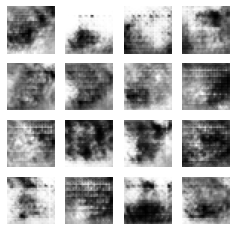

Time for training : 1192 sec


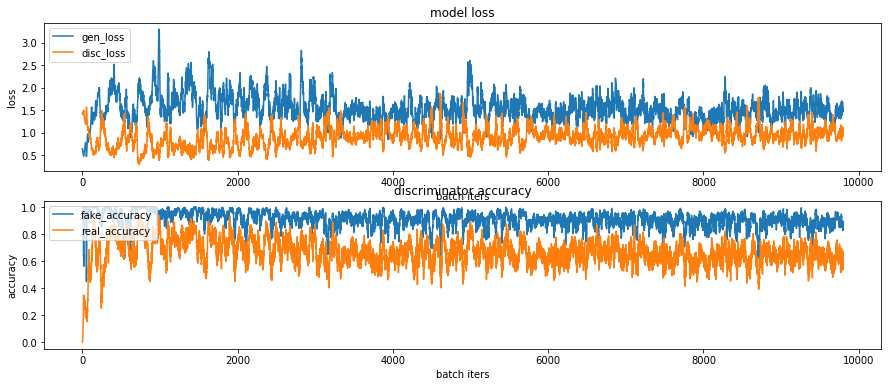

CPU times: user 13min, sys: 1min 29s, total: 14min 30s
Wall time: 19min 53s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
# 학습과정 시각화

anim_file = os.getenv('HOME')+'/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1290292 Sep 28 16:26 /aiffel/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/cifar10_dcgan.gif


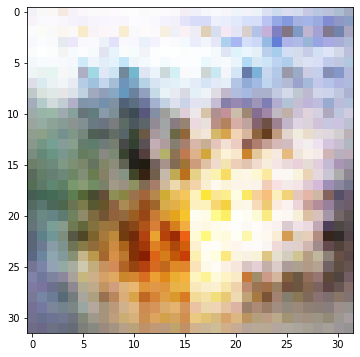

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/exploration/fashion_mnist/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 회고

학습과정을 gif파일로 만들어서 볼 수 있다는 것이 인상적이었다. 이번 프로젝트에서는 훈련 모델의 레이어나 하이퍼파라미터의 수정 등 모델을 튜닝할 수 있는 부분이 많아서 어디를 튜닝하는 것이 효율적일지 고민이 많았다. 생성된 모델의 화질이 좋지 않아서 육안으로 이게 무엇인지는 알 수 없지만 cifar10의 모델과 비교해보면 나름 괜찮게 나왔다는 생각도 들었다. 위의 프로젝트에서는 생성자와 판별자를 만들었는데 다른 일반적인 강화학습 모델로 만들어도 괜찮을 것 같다는 생각을 했다.
찾아보니 Conditional GAN, Progressive GAN, SN-GAN 등의 모델이 있었는데 이를 이용해보고 싶다는 생각도 들었다.